<a href="https://colab.research.google.com/github/Juanba98/Algorithmic_Trading/blob/main/quant_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Quantitative Analysis of Price & Daily Returns
* Can returns be described with a normal distribution?
* Is daily change non-zero?
* Can price movement be described as a random walk?

### 1. Set up environment 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()
import pandas_datareader.data as web

### 2.  Download stock price data, store in dataframe

In [4]:
amzn = web.DataReader(name='AMZN', data_source='yahoo')

### 3. Take a look at the data

In [24]:
amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-10-03,48.184502,47.518501,47.900002,47.855000,53332000.0,47.855000
2017-10-04,48.389500,47.702499,47.710499,48.272499,50548000.0,48.272499
2017-10-05,49.075500,48.481998,48.500000,49.042500,64584000.0,49.042500
2017-10-06,49.787498,48.782001,48.782001,49.479000,75642000.0,49.479000
2017-10-09,49.924999,49.375000,49.661999,49.549500,58772000.0,49.549500
...,...,...,...,...,...,...
2022-09-26,117.339996,113.129997,113.300003,115.150002,62723300.0,115.150002
2022-09-27,118.320000,113.050003,117.199997,114.410004,60094700.0,114.410004
2022-09-28,118.699997,113.800003,114.379997,118.010002,55763800.0,118.010002


### 4. Store instantaneous rate of return in separate series

In [31]:
amzn_close = amzn['Close']
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html
# diff() => output[i] = row[i] - row[i+1] 
amzn_return  =  round(np.log(amzn_close).diff() * 100, 2)
amzn_return

Date
2017-10-03     NaN
2017-10-04    0.87
2017-10-05    1.58
2017-10-06    0.89
2017-10-09    0.14
              ... 
2022-09-26    1.20
2022-09-27   -0.64
2022-09-28    3.10
2022-09-29   -2.76
2022-09-30   -1.58
Name: Close, Length: 1258, dtype: float64

### 5. Plot the series 

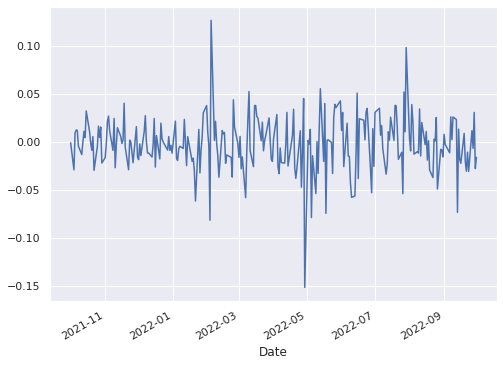

In [25]:
amzn_return[-252:].plot()

### 6. Pandas describe function gives descriptive statistics, default assumes you are dealing with a sample Pandas also deals with missing values by omitting them 

In [32]:
amzn_return.dropna(inplace=True)
amzn_return.describe()

count    1257.000000
mean        0.068385
std         2.186879
min       -15.140000
25%        -0.940000
50%         0.140000
75%         1.130000
max        12.690000
Name: Close, dtype: float64

### 7. An alternative more slightly  different table of descriptives from scipy stats

In [27]:
from scipy import stats

In [35]:
n, minmax, mean, var, skwe, kurt = stats.describe(amzn_return)
mini, maxi = minmax
std = var ** .5

Fischer's kurtosis, which means it has been normalized. This subtracts 3 from the calculation, so this unnormalized is 7.4 and this describes that there is more observation towards the center. It also tends to mean that there are tails. So we can think that there are a lot of "boring" days and often we have these big days

### 9. for comparision generate random numbers that follow normal distribution


In [39]:
from scipy.stats import norm

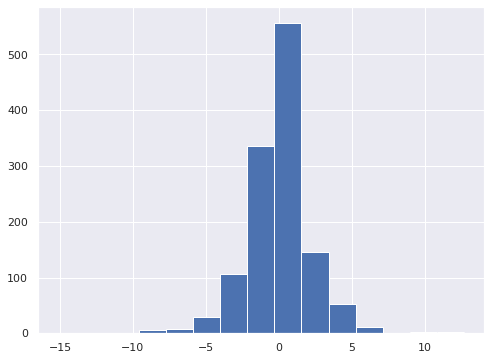

In [42]:
#; to suppress meaningless data
plt.hist(amzn_return, bins = 15);

In [46]:
#rvs => Random variates.
x = norm.rvs(mean, std, n)

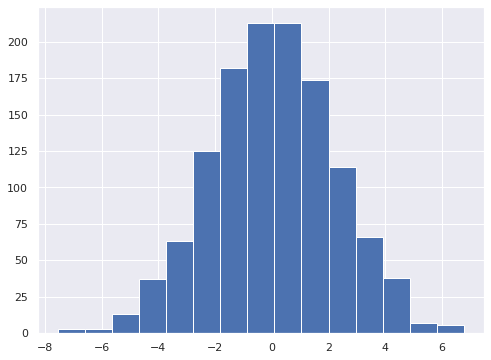

In [45]:
plt.hist(x, bins = 15);

## Is price change normally distributed?

### 10. Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [48]:
#Test whether a dataset has normal kurtosis.
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

     Test statistic         p-value
     ------------------------------
x:             0.70          0.4869
AMZN:         12.05          0.0000


This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution. So we have a very low p-value, so we reject $H_{0}$, which means we can't say that amzn_return follows a normal distribution.

### 11. plot histogram of price changes with normal curve overlay


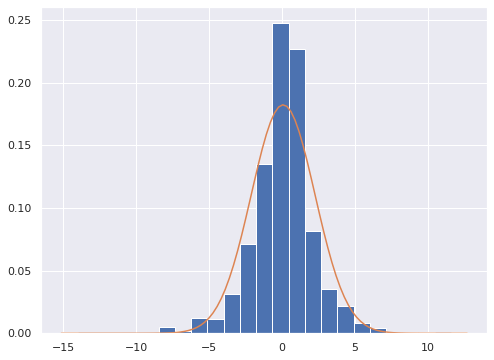

In [55]:
plt.hist(amzn_return, bins = 25, edgecolor='w', density = True);
overlay = np.linspace(mini, maxi, 100)
#norm.pdf => Probability density function.
plt.plot(overlay, norm.pdf(overlay, mean, std));

### 12. Compare normally distributed sample with same attributes as amzn price change

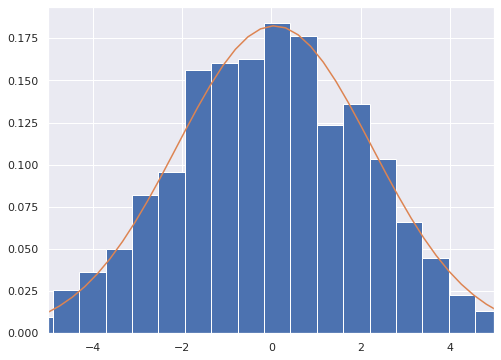

In [57]:
plt.hist(x, bins =25, density = True)
b = np.linspace(mini, maxi, 100)
plt.plot(b,norm.pdf(b, mean, std))
plt.xlim(-5,5);

## Is daily price change significantly different from zero?

### 13. Conduct simple hypothesis test

In [63]:
# Calculates the T-test for the mean of ONE group of scores.
# popmean(0) => Expected value in null hypothesis
# two-sided => The mean of the underlying distribution of the sample is different than the given population mean (0)
stats.ttest_1samp(amzn_return.sample(252), 0, alternative = 'two-sided')

Ttest_1sampResult(statistic=1.6037614148660784, pvalue=0.1100241967380132)

So we have a 22% chance that if we reject the null we will be making a mistake. 

## Can price movement be described as a random walk?

### 14. Create price lags

If the price is a random walk then it's going to be hard to predict 

In [66]:
amzn_close = pd.DataFrame(amzn_close, columns = ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace = True)
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
2017-10-05,49.042500,48.272499,47.855000
2017-10-06,49.479000,49.042500,48.272499
2017-10-09,49.549500,49.479000,49.042500
2017-10-10,49.360001,49.549500,49.479000
2017-10-11,49.750000,49.360001,49.549500


### 15. Fit linear model

In [78]:
# np.linalg.lstsq => Return the least-squares solution to a linear matrix equation.(Ax = b)
# return Least-squares solution
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close['Close'], rcond = None)[0]
lr

array([0.96906017, 0.03099705])

96% of tomorrow's price can be predicted by today's 

In [77]:
#np.dot() => Dot product of two arrays.
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2017-10-05,49.042500,48.272499,47.855000,48.262320
2017-10-06,49.479000,49.042500,48.272499,49.021438
2017-10-09,49.549500,49.479000,49.042500,49.468301
2017-10-10,49.360001,49.549500,49.479000,49.550149
2017-10-11,49.750000,49.360001,49.549500,49.368699


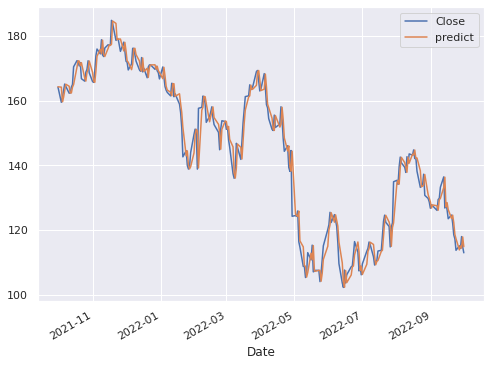

In [75]:
amzn_close.iloc[-252:][['Close','predict']].plot()